<img src='imgs/finra-small.png' align='left'>
<br><br><br>

# Model Monitor Demo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler

import yfinance as yf

## The modelmonitor Library
Right now, the `ModelMonitor` object is the only class contained in the library.

You may view its source code and this demo [here](https://github.com/timbook/modelmonitor).

In [2]:
from modelmonitor import ModelMonitor

### Read daily stock data from your favorite symbol via YahooFinance API

In [3]:
symbol = 'YUM'
data = yf.download(symbol, period='5y', interval='1d', progress=False)
data.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
data['date'] = pd.to_datetime(data.index)
data['year'] = data['date'].dt.year
data.drop(columns='date', inplace=True)

In [4]:
data.head()

,open,high,low,close,adjclose,volume,year
Date,,,,,,,
2015-11-24,51.646297,52.250179,51.488136,52.034508,47.603897,3045400,2015
2015-11-25,52.242992,52.401150,52.099209,52.185478,47.742012,3222800,2015
2015-11-27,52.257370,52.480228,51.905106,52.451473,47.985367,2558800,2015
2015-11-30,52.329258,52.530552,52.063263,52.127964,47.689392,4477400,2015
2015-12-01,52.624012,53.774261,52.624012,53.544212,48.985050,7057500,2015


In [5]:
data.tail()

,open,high,low,close,adjclose,volume,year
Date,,,,,,,
2020-11-17,103.480003,104.309998,103.010002,104.040001,104.040001,1000200,2020
2020-11-18,104.419998,105.019997,103.769997,104.169998,104.169998,1288000,2020
2020-11-19,104.160004,105.400002,103.820000,105.269997,105.269997,1081500,2020
2020-11-20,105.160004,105.459999,104.680000,104.989998,104.989998,1541200,2020
2020-11-23,105.589996,105.839996,104.489998,105.000000,105.000000,1449100,2020


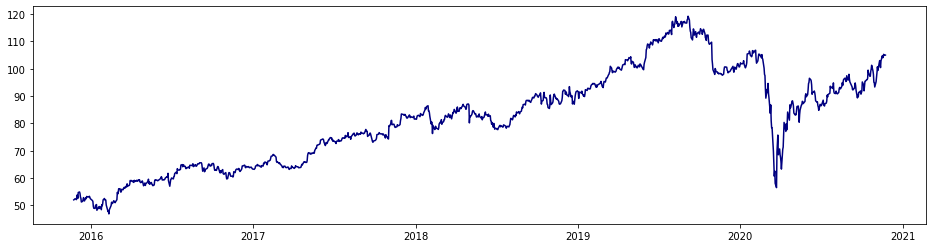

In [6]:
plt.figure(figsize=(16, 4))
plt.plot(data.index, data.close, color='navy');

Two example distance metrics

In [7]:
ks = lambda v, w: stats.ks_2samp(v, w).statistic
wass = lambda v, w: stats.wasserstein_distance(v, w)

### Step 1: Instantiate `ModelMonitor` object
Object has a few parameters, most optional:
* `labels` and `sep` - Column labels when using more than two data sources
* `subset` - List of columns (as strings) to subset to if given too many, or if inputs are inconsistent

In [8]:
mm = ModelMonitor(metric=ks)

### Step 2: Evaluate

Demo: Distances between all features across the two given days

In [9]:
# data15 = data[data.year == 2015].drop(columns='year')
data16 = data[data.year == 2016].drop(columns='year')
data17 = data[data.year == 2017].drop(columns='year')
data18 = data[data.year == 2018].drop(columns='year')

In [10]:
mm.evaluate(data16.close, data17.close) 

0.7849079870992222

In [11]:
mm.evaluate(data16.close, data17.close, data18.close) 

[0.7849079870992222, 0.8326693227091634]

In [12]:
mm.evaluate(data17, data18)

open        0.832669
high        0.836653
low         0.828685
close       0.832669
adjclose    0.836653
volume      0.047809
dtype: float64

As we can see, the difference between closes is very high, but the difference between volumes isn't nearly so extreme.

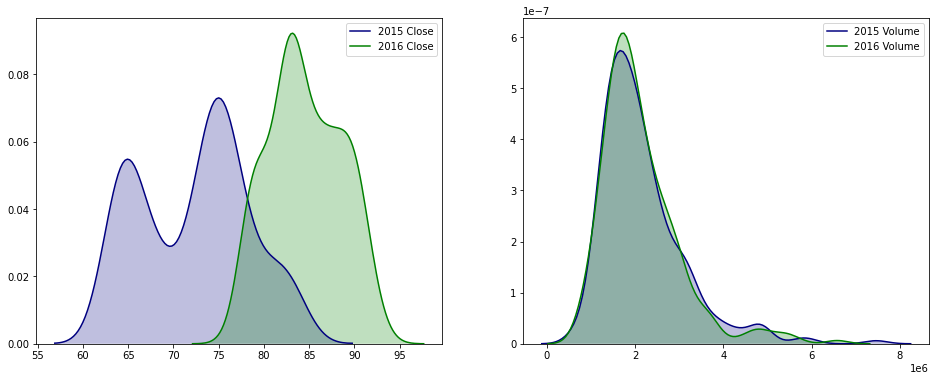

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.kdeplot(data17.close, shade=True, color='navy', label='2015 Close', ax=axs[0])
sns.kdeplot(data18.close, shade=True, color='green', label='2016 Close', ax=axs[0])
sns.kdeplot(data17.volume, shade=True, color='navy', label='2015 Volume', ax=axs[1])
sns.kdeplot(data18.volume, shade=True, color='green', label='2016 Volume', ax=axs[1]);

In [14]:
mm.evaluate(data16, data17, data18, labels=[2016, 2017, 2018])

,2016_2017,2017_2018
open,0.776987,0.832669
high,0.776956,0.836653
low,0.773066,0.828685
close,0.784908,0.832669
adjclose,0.837033,0.836653
volume,0.598179,0.047809


Demo: Many values for entire DataFrames

In [15]:
mm.evaluate(data, groupby='year')

,2015_2016,2016_2017,2017_2018,2018_2019,2019_2020
open,0.833333,0.776987,0.832669,0.936492,0.554017
high,0.837302,0.776956,0.836653,0.940429,0.537270
low,0.833333,0.773066,0.828685,0.940476,0.562828
close,0.829365,0.784908,0.832669,0.944429,0.557548
adjclose,0.841270,0.837033,0.836653,0.944429,0.502465
volume,0.286325,0.598179,0.047809,0.264893,0.182592


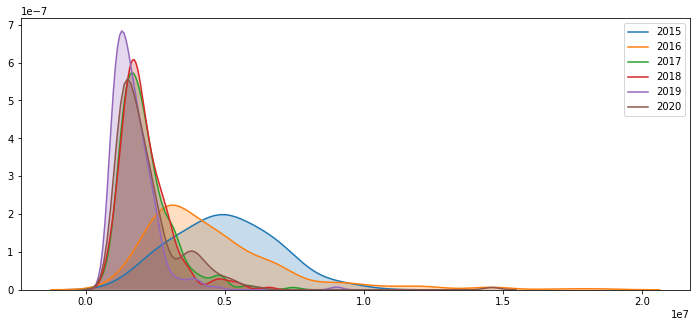

In [16]:
plt.figure(figsize=(12, 5))
years = data.year.unique().tolist()
for year in years:
    sns.kdeplot(data.loc[data.year == year, 'volume'], shade=True, label=year)